In [209]:
import numpy as np
from numpy import linalg as la
from scipy import linalg as spla
import matplotlib.pyplot as plt
import math
import cmath

%matplotlib inline

# Filters basics

In [2]:
def shift(x, k, default = 0):
    """shifts the elements of the given numpy array by k entries
    and pads the rest with the given default value"""
    x=np.roll(x, k)
    if k < 0:
         np.put(x, range(len(x)+k, len(x)), default)
    elif k > 0:
         np.put(x, range(k), default)
    return x

In [8]:
def periodic_convolute(a, b, n):
    a_len = len(a)
    b_len = len(b)
    
    # pad both vectors to the length equal the period:
    a = np.pad(a, (0, n - a_len), "constant", constant_values=0)
    b = np.pad(b, (0, n - b_len), "constant", constant_values=0)
    
    mat = np.empty((n, n))
    
    for cIdx in range(n):
        mat[:,cIdx] = np.roll(b, cIdx)
    
    return mat @ a

In [9]:
def convolute_using_matrix(h, x):
    """convolution of the two given vectors (as numpy arrays)
    by building a convolution matrix first (just for learning)"""
    m = len(x) + len(h) - 1
    n = len(x)
    mat = np.zeros((m, n))
    
    for cIdx in range(len(x)):
        mat[cIdx:cIdx + len(h),cIdx] = h
    return mat @ x

def convolute(h, x):
    """convolution of the two given vextors (as numpy arrays)"""
    m = len(x) + len(h) - 1
    res = np.zeros((m))
    for k in range(m):
        for j in range(len(x)):
            if k-j >= 0 and k-j < len(h):
                res[k] += x[j] * h[k-j]
    
    assert np.array_equal(res, convolute_using_matrix(h, x))
    return res
    
    


In [10]:
def create_lt_fir(ir):
    """creates a new LT_FIR (linear, time-invariant, finite [casual] filter) filter by providing the inpulse response of the filter"""
    def f(x):
        return convolute(ir, x)
    return f

In [11]:
def create_periodic_lt_fir(ir):
    """creates a new periodic LT_FIR (linear, time-invariant, finite [casual] filter) filter by providing the inpulse response of the filter"""
    def f(x):
        return periodic_convolute(ir, x, len(ir))
    return f

In [14]:
F1 = create_lt_fir([1, 2, 3])
print(F1([1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3]))
F2 = create_periodic_lt_fir([1, 2, 3])
print(F2([1, 2, 3]))

[ 1.  4. 10. 13. 13. 10. 13. 13. 10. 13. 13. 10. 13. 13. 10. 12.  9.]
[13. 13. 10.]


# Circular Matrices

## Plotting real/imaginary values of all eigenvectors of a random circular matrix

In [248]:
def create_circular_matrix(u):
    """creates a circular matrix using the column vector u"""
    n = len(u)
    C = np.zeros((n, n))
    for cIdx in range(n):
        C[:,cIdx] = np.roll(u, cIdx)
    
    return C

In [254]:
def create_dfm_from_circular(C):
    """returns a fourier matrix calculated from the eigenvectors of a given circular matrix
    still not working :((( """
    print(C)
    n = len(C)
    _, eigenvectors = la.eig(C)
    F = eigenvectors * math.sqrt(n)
    F_exp = spla.dft(n)
    
    print(F)
    print("-----")
    print(F_exp)

    assert np.array_equal(F, F_exp)
    
    return F

In [267]:
def w(n):
    t = cmath.exp(2j * math.pi / float(n))
    """returns a function returning the k-th solution of the n-th root of unitiy, for a given n"""
    def f(k):
        return t ** k
    return f

def create_dfm_from_root(n):
    """returns a fourier matrix created using different powers of the n-th root of unity"""
    C = np.zeros((n, n), dtype=complex)
    w_n = w(n)
    for r in range(n):
        for c in range(n):
            v = w_n(r * c)
            C[r,c] = v
    
    # by definition:
    C = C.conj()
    
    return C

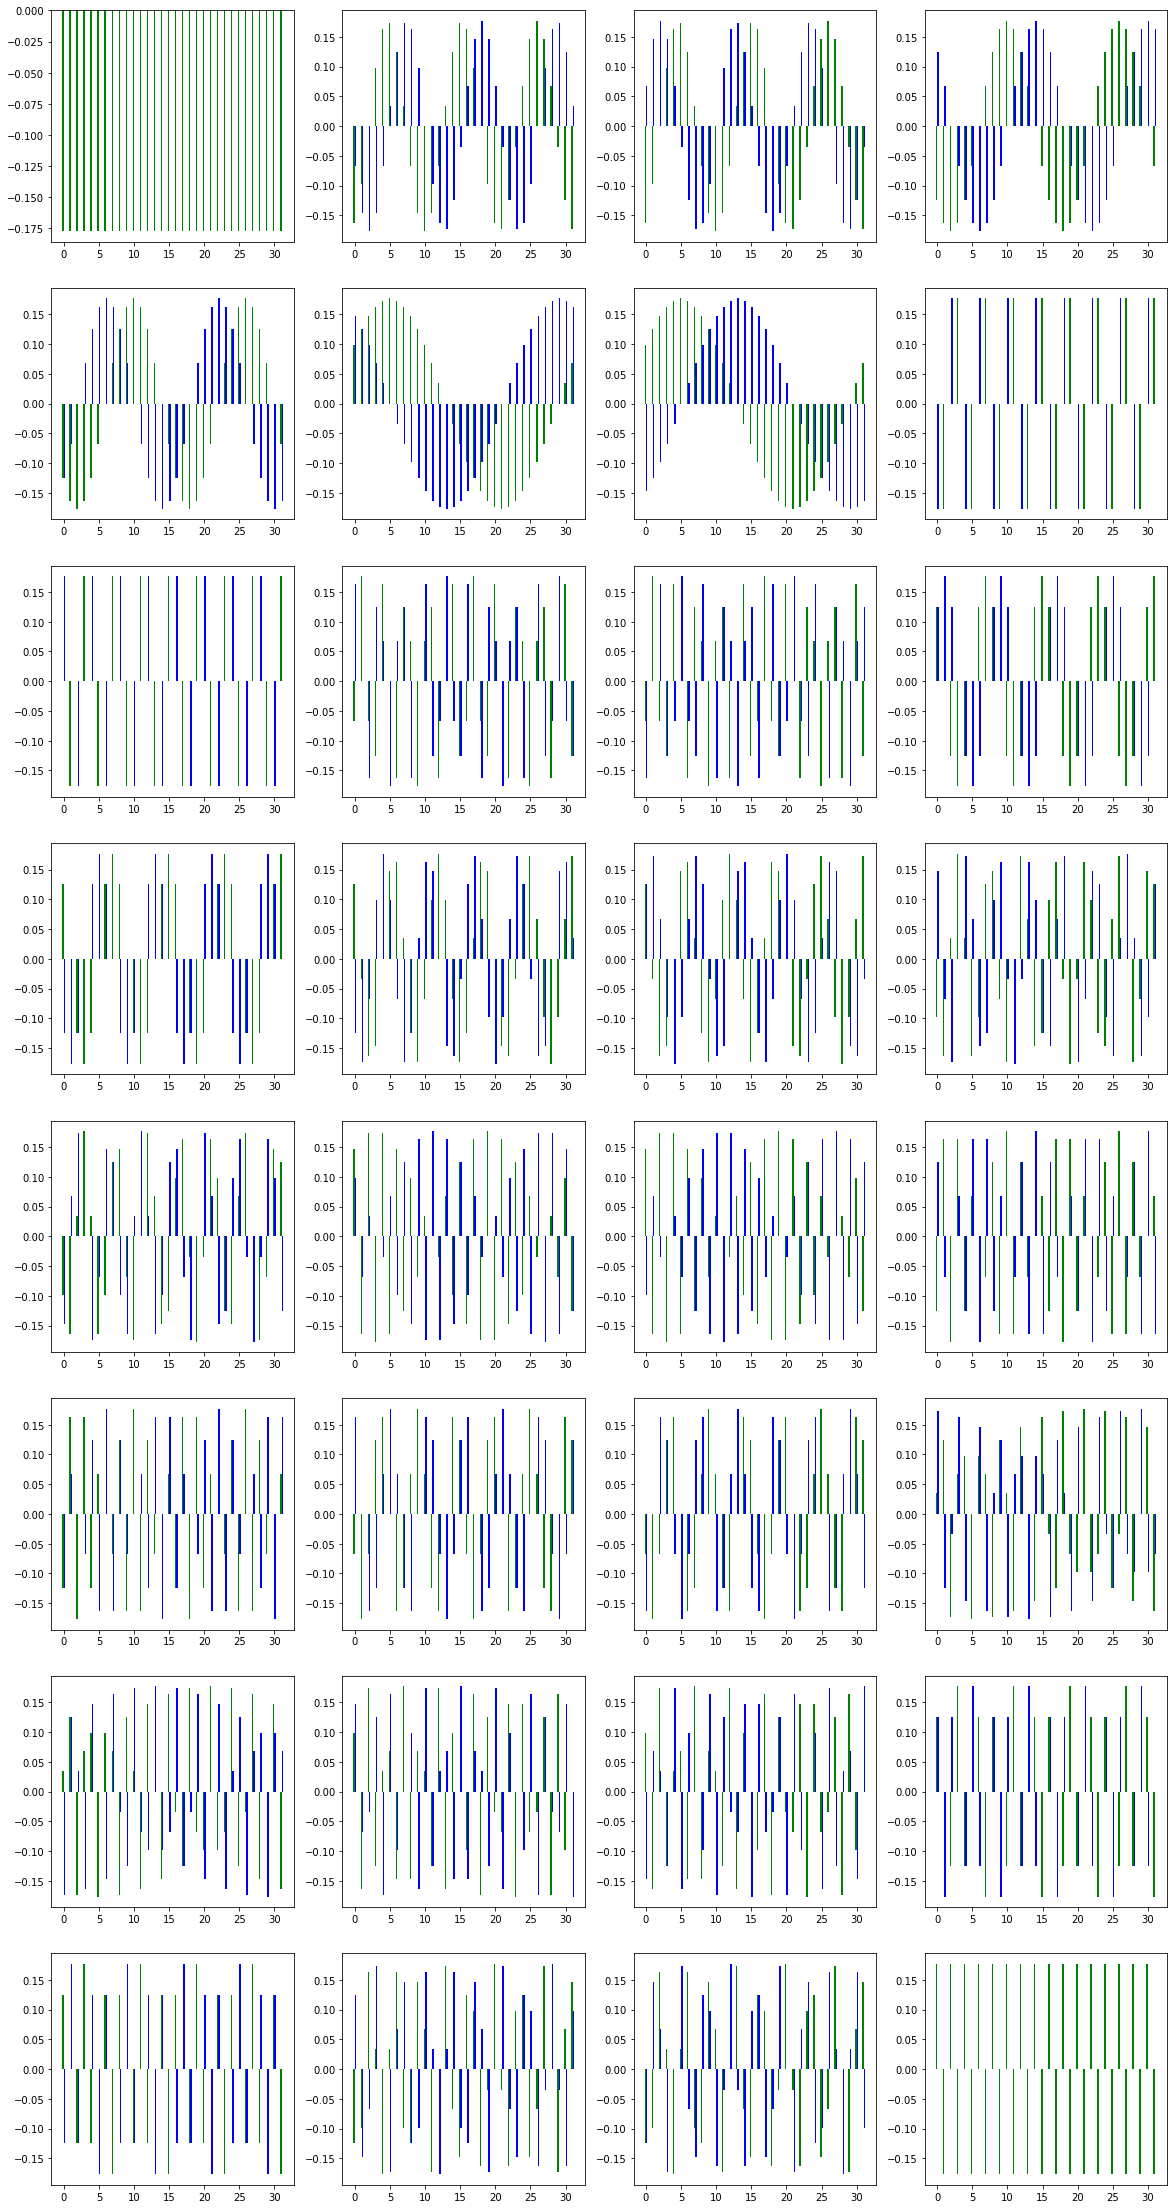

In [175]:
n = 32
col = np.random.rand(n)
# random circular matrix
C = create_circular_matrix(col)
_, evs = la.eig(C)

comp_indices = np.array(range(n))
maxplots = min(n, 32)
cols = 4

rows = math.ceil(maxplots / float(cols))
fig, axs = plt.subplots(rows, cols, figsize=(20, 5 * rows))
for i in range(maxplots):
    r = int(i / cols)
    c = i % cols
    ax = axs[r, c] if rows > 1 and cols > 1 else axs[c] if cols > 1 else axs[r]
    ax.bar(comp_indices-0.1, np.real(evs[:,i]), color='green', width=0.2)
    ax.bar(comp_indices+0.1, np.imag(evs[:,i]), color='blue', width=0.2)

## Using Fourier-Mats to solve convolutions
1. Fourier-Mat $F_n$ of C is matrix of eigenvectors of C transposed
2. $C\bar{F_n} = \bar{F_n}\text{diag}(d_1, \dots, d_n), [d_1, \dots, d_n]^T = F_n[u_0, \dots, u_n]$, where $u_i$ are the columns of $C$
3. $z = Cx \implies z = F_n^{-1}\text{diag}(F_nu)\cdot F_nx$

Therefore, we can solve a periodic convolution using Fourier-matrices instead:

In [272]:
input_n = 3
n = 2*input_n - 1

a = np.array([1, 2, 3])
a_ext = np.pad(a, (0, n - len(a)))
b = np.array([1, 2, 3])
b_ext = np.pad(b, (0, n - len(b)))

F_n = create_dfm_from_root(n)

z_1 = la.inv(F_n) @ ((F_n @ b_ext) * (F_n @ a_ext))

print("using dft:  {}".format(np.around(z_1)))
print("using conv: {}".format(periodic_convolute(a, b, n)))

using dft:  [ 1.+0.j  4.+0.j 10.+0.j 12.-0.j  9.-0.j]
using conv: [ 1.  4. 10. 12.  9.]
